# Exploring employee reviews

In this notebook I'll take a look at the dataset published [here](https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews) on employee reviews for some of the biggest US tech companies.

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk import word_tokenize
from datetime import datetime
from textblob import TextBlob

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

import gensim
import os

## Data loading and cleanup

In [2]:
data_path = 'data/employee_reviews.csv'

In [3]:
df = pd.read_csv(data_path)

I'll start by doing some standard cleaning up of the dataset

In [4]:
df = df.drop(['Unnamed: 0', 'helpful-count', 'link'], axis=1)

Also, by taking a look at the data it seems clear that the `summary` field does not convey any useful information so I'll just drop it.

In [5]:
df = df.drop(['summary'], axis=1)

Here what the data looks like after the cleaning

In [6]:
df[:5]

,company,location,dates,job-title,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars
0,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0
1,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0
2,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0
3,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0
4,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0


## Helper functions

Let's define a few helper functions to make everything more readable

In [57]:
def plot_by_year(df, years, company=[], embed='tsne'):
    """
    Plot only the document centroids of a given year
    
    """
    
    y_df = df.loc[df['date'].isin(years)]
    if company:
        y_df = y_df.loc[y_df['company'].isin(company)]
    print(y_df.describe())
    
    comp = list(y_df['company'])
    comp_order = {sorted(list(set(comp)))[i]: i for i in range(len(set(comp)))}
    comp_c = [comp_order[c] for c in comp]
    
    if embed == 'tsne':
        x_crd = list(y_df['cent_t_x'])
        y_crd = list(y_df['cent_t_y'])
    else:
        x_crd = list(y_df['cent_p_x'])
        y_crd = list(y_df['cent_p_y'])

    fig, ax = plt.subplots(1,1, figsize=(15,15))
    
    cmap = plt.cm.get_cmap('Set2')
    cmaplist = [cmap(i) for i in range(len(set(comp)))]

    graph = plt.scatter(
        x_crd, 
        y_crd,
        c=comp_c,
        label=comp,
        cmap=mpl.colors.ListedColormap(cmaplist),
        alpha=0.3
    )
    ax.set_title('TSNE of word2vec embeddings')
    
    plt.show()    

## Word2Vec model

One thing that would be interesting is to try to cluster the reviews based on their textual content.

To do that I'll load a Word2Vec pretrained model from Google using gensim.

In [8]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    '/media/giorgio/inbar_hd/models/GoogleNews-vectors-negative300.bin', 
    binary=True
)  

Let's print out the vector for a random word to make sure the model was loaded correctly.

In [9]:
print(model['easy'][:5])

[ 0.30664062  0.06835938 -0.16015625  0.11962891 -0.00656128]


In [10]:
# This saves up memory
model.init_sims(replace=True)

## Data preprocessing

Before we can actually use the pretrained model to vectorize our corpus of reviews, we should preprocess the data to make it more manageable. I'll also stitch together the three sections of each review in a single string.

In [11]:
pros = list(df['pros'])
cons = list(df['cons'])
advm = list(df['advice-to-mgmt'])

There seems to be a few entries of the advice to management section being misinterpreted as floats.

In [12]:
for i in range(len(pros)):
    if type(pros[i]) is not str or type(cons[i]) is not str or type(advm[i]) is not str:
        print(pros[i], cons[i], advm[i])
        print('-'*80)
        break

Lots of learning opportunities at here not for now, everything is good. nan
--------------------------------------------------------------------------------


In [13]:
if len(pros) == len(cons) and len(cons) == len(advm):
    revs = [str(pros[i]) + ' ' + str(cons[i]) + ' ' + str(advm[i]) for i in range(len(pros))] 
else:
    print('Different number of reviews')

In [24]:
print(revs[2])

* If you're a software engineer, you're among the kings of the hill at Google. It's an engineer-driven company without a doubt (that *is* changing, but it's still very engineer-focused). * The perks are amazing. Yes, free breakfast, lunch, an dinner every weekday. Aaaaaamazing holiday parties (at Waldorf Astoria, NY Public Library, MoMA, etc.), overnight ski trips to Vermont, overnight nature trips to the Poconos in the summer, summer picnics at Chelsea piers, and on and on and on. I don't see this going away unless the company starts hurting financially. * Speaking of which, the company is doing quite well, which reflects in bonuses and equity grants. * There a huge diversity of work ranging from defending independent journalism worldwide (Google Project Shield) to crisis response during disasters (see Maps during Hurricane Sandy or Tsunamis), to the best machine learning experts and projects in the world, to more mundane revenue-driving projects in advertising, there's really somethi

We can now use nltk to tokenize and remove stopwords

In [15]:
stop_words = stopwords.words('english')

In [19]:
revs_pre = [[word.lower() for word in word_tokenize(doc) if word.lower() not in stop_words and word.isalpha()] for doc in revs]

In [20]:
revs_pre = [doc[:-1] if doc[-1] in ['none', 'nan'] else doc for doc in revs_pre]

We will also need to remove words not in the model's dictionary

In [21]:
revs_fin = []
for doc in revs_pre:
    doc = [word for word in doc if word in model.vocab]
    if not doc: continue
    revs_fin.append(doc)

In [23]:
print(len(revs), len(revs_pre), len(revs_fin))

67529 67529 67529


In [25]:
print(revs_fin[2])

['software', 'engineer', 'among', 'kings', 'hill', 'google', 'company', 'without', 'doubt', 'changing', 'still', 'perks', 'amazing', 'yes', 'free', 'breakfast', 'lunch', 'dinner', 'every', 'weekday', 'holiday', 'parties', 'ny', 'public', 'library', 'moma', 'etc', 'overnight', 'ski', 'trips', 'vermont', 'overnight', 'nature', 'trips', 'summer', 'summer', 'picnics', 'chelsea', 'piers', 'see', 'going', 'away', 'unless', 'company', 'starts', 'hurting', 'financially', 'speaking', 'company', 'quite', 'well', 'reflects', 'bonuses', 'equity', 'grants', 'huge', 'diversity', 'work', 'ranging', 'defending', 'independent', 'journalism', 'worldwide', 'google', 'project', 'shield', 'crisis', 'response', 'disasters', 'see', 'maps', 'hurricane', 'sandy', 'tsunamis', 'best', 'machine', 'learning', 'experts', 'projects', 'world', 'mundane', 'projects', 'advertising', 'really', 'something', 'everybody', 'easy', 'move', 'around', 'within', 'company', 'long', 'good', 'standing', 'vast', 'majority', 'engine

## Document vector embedding

Now let's find out the centroid for each document

In [27]:
centroids = [np.mean(model[doc], axis=0) for doc in revs_fin]

In [28]:
len(centroids[0])

300

Now that we have our 300-dimensional document centroid embeddings we can use a dimensionality reduction technique such as tsne to obtain a 2D representation of the data. Before using TSNE though, it is recommended to use PCA to lower the dimensionality to a reasonable threshold.

In [29]:
cents_pca = PCA(n_components=50).fit_transform(centroids)

In [30]:
cents_tsne = TSNE(n_components=2).fit_transform(cents_pca)

In [31]:
cents_pca = PCA(n_components=2).fit_transform(centroids)

Let's save the results on disk, since losing them would mean wasting a few hours of computation.

In [32]:
np.save(open('res/tsne_review_centroids_tsne', 'wb'), cents_tsne)

In [33]:
np.save(open('res/tsne_review_centroids_pca', 'wb'), cents_pca)

In [ ]:
# or just load the coordinates if already computed
cents_tsne = np.load('res/tsne_review_centroids_tsne')
cents_pca = np.load('res/tsne_review_centroids_pca')

In [34]:
print(len(cents_tsne), cents_tsne[0])
print(len(cents_pca), cents_pca[0])

67529 [7.4388647 6.1053267]
67529 [ 0.03908568 -0.00185025]


In [38]:
x_crd_t,y_crd_t = zip(*cents_tsne)
print(len(x_crd_t), len(y_crd_t), x_crd_t[0], y_crd_t[0])

67529 67529 7.4388647 6.1053267


In [39]:
x_crd_p,y_crd_p = zip(*cents_pca)
print(len(x_crd_p), len(y_crd_p), x_crd_p[0], y_crd_p[0])

67529 67529 0.03908568276006658 -0.0018502502267663953


## Splitting by date

This representation unfortunately is not really helpful due to the huge amount of data points.

Let's try to scale the problem to a more manageable size by dividing the reviews by year.

In [35]:
date = []

In [36]:
for d in list(df['dates']):
    d = d.strip().lower()
    if not d or d == 'none' or d == 'nan' or '0, 0000' in d:
        date.append(datetime.fromtimestamp(1).year)
    else:
        date.append(datetime.strptime(d, '%b %d, %Y').year)

In [37]:
print(Counter(date).most_common())

[(2017, 14075), (2018, 13676), (2016, 11490), (2015, 10140), (2014, 5941), (2013, 3859), (2012, 3210), (2011, 1710), (2008, 1365), (2010, 1130), (2009, 929), (1969, 4)]


Let's now create a new dataframe with only the processed data

In [84]:
proc_df = pd.DataFrame()

proc_df['company'] = df['company']
proc_df['date']    = date
proc_df['review']  = revs
proc_df['cent_t_x']  = x_crd_t
proc_df['cent_t_y']  = y_crd_t
proc_df['cent_p_x']  = x_crd_p
proc_df['cent_p_y']  = y_crd_p
proc_df['rate']    = df['overall-ratings']

proc_df[:5]

,company,date,review,cent_t_x,cent_t_y,cent_p_x,cent_p_y,rate
0,google,2018,People are smart and friendly Bureaucracy is s...,7.438865,6.105327,0.039086,-0.001850,5.0
1,google,2013,"1) Food, food, food. 15+ cafes on main campus ...",-2.646656,-5.338993,-0.026424,0.039715,4.0
2,google,2014,"* If you're a software engineer, you're among ...",0.688755,-7.485783,-0.022087,0.073461,5.0
3,google,2015,You can't find a more well-regarded company th...,9.251099,-6.508359,0.027527,0.059653,5.0
4,google,2018,Google is a world of its own. At every other c...,-3.905935,-6.832077,-0.034405,0.053819,5.0


## Review by year

         date    cent_t_x    cent_t_y    cent_p_x    cent_p_y        rate
count   223.0  223.000000  223.000000  223.000000  223.000000  223.000000
mean   2015.0    2.027718    1.768057    0.006269    0.006056    4.479821
std       0.0   13.310954   10.318015    0.059079    0.040358    0.962493
min    2015.0  -25.751637  -24.864964   -0.163017   -0.124413    1.000000
25%    2015.0   -7.622063   -5.063001   -0.032444   -0.018024    4.000000
50%    2015.0    2.322191    0.635754   -0.001527    0.009018    5.000000
75%    2015.0   13.204009    7.627849    0.043009    0.031091    5.000000
max    2015.0   36.404572   30.237091    0.291868    0.131498    5.000000


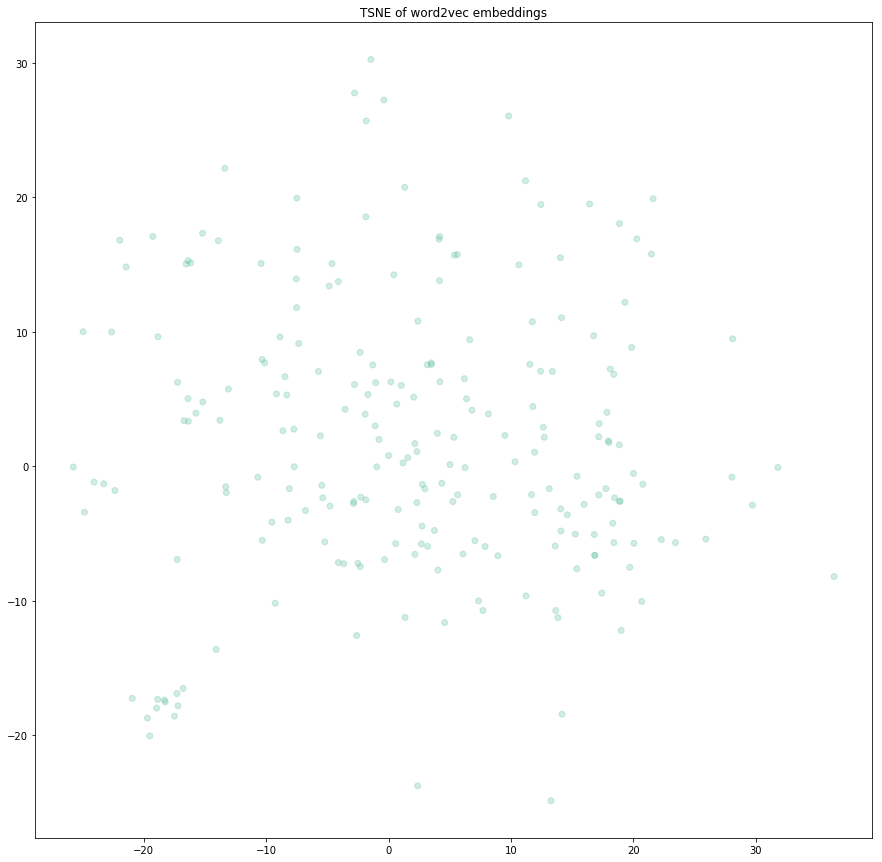

In [61]:
plot_by_year(proc_df, [2015], company=['facebook'], embed='tsne')

         date    cent_t_x    cent_t_y    cent_p_x    cent_p_y        rate
count   223.0  223.000000  223.000000  223.000000  223.000000  223.000000
mean   2015.0    2.027718    1.768057    0.006269    0.006056    4.479821
std       0.0   13.310954   10.318015    0.059079    0.040358    0.962493
min    2015.0  -25.751637  -24.864964   -0.163017   -0.124413    1.000000
25%    2015.0   -7.622063   -5.063001   -0.032444   -0.018024    4.000000
50%    2015.0    2.322191    0.635754   -0.001527    0.009018    5.000000
75%    2015.0   13.204009    7.627849    0.043009    0.031091    5.000000
max    2015.0   36.404572   30.237091    0.291868    0.131498    5.000000


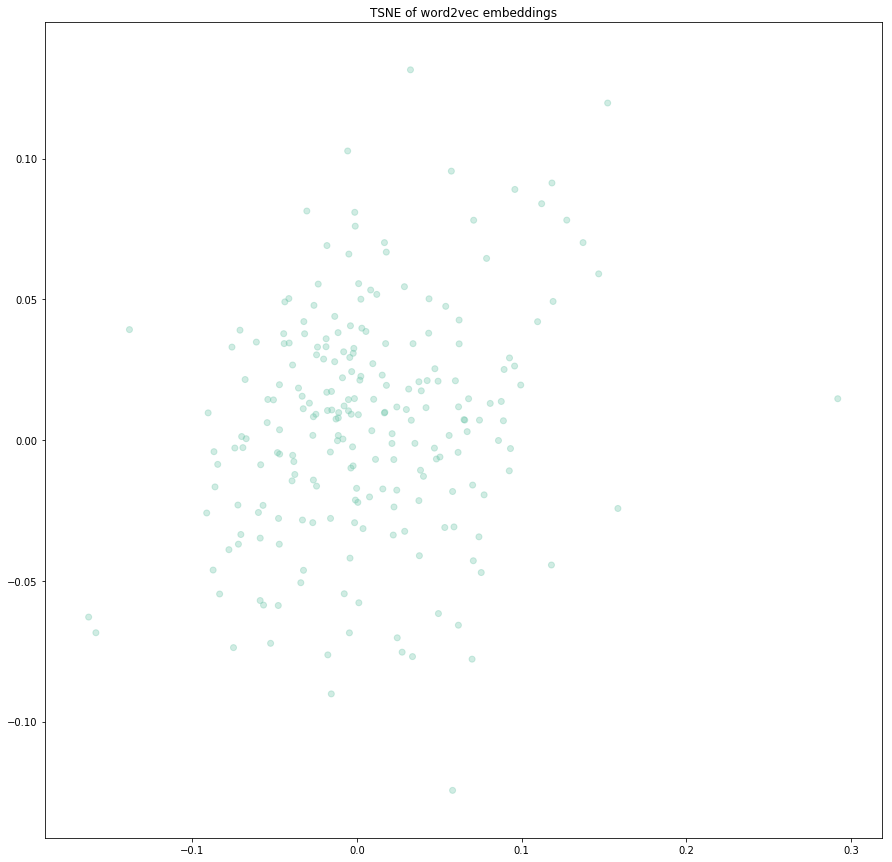

In [60]:
plot_by_year(proc_df, [2015], company=['facebook'], embed='pca')

## Star ratings

In addition to the reviews it would also be interesting to know the star ratings count for each company

In [50]:
comp = list(df['company'])
ovrl = list(df['overall-ratings'])

In [64]:
star = defaultdict(lambda: defaultdict(Counter))
for i in range(len(comp)):
    star[comp[i]][date[i]][ovrl[i]] += 1

## Sentiment classification

Finally let's try to do some sentiment classification on the reviews and see how it maps with the 2D representations.

In [69]:
pol_sub = [TextBlob(r).sentiment for r in revs]

In [88]:
print(revs[329])

benefits, time, vacation you can work on what you want no life your project might be irrelevant none


In [70]:
print(len(pol_sub), pol_sub[0])

67529 Sentiment(polarity=0.14457671957671958, subjectivity=0.47724867724867726)


In [72]:
pols, subj = zip(*pol_sub)

In [85]:
proc_df['polarity']  = pols
proc_df['subjectivity'] = subj

Now that we have enough preprocessed data, let's output everything to files, divided by year

In [96]:
type(proc_df.index.name)

NoneType

In [90]:
for y in range(2009, 2019):
    y_df = proc_df.loc[proc_df['date'] == y]
    y_df.to_csv('res/review_' + str(y), sep=',', encoding='utf-8')

In [91]:
proc_df.loc[proc_df['date'] == 2009].min()

company                                                    amazon
date                                                         2009
review          (1) Good Benefits (2) Lot of opportunities to ...
cent_t_x                                                 -29.0497
cent_t_y                                                 -29.0954
cent_p_x                                                -0.238505
cent_p_y                                                -0.211205
rate                                                            1
polarity                                                     -0.6
subjectivity                                                    0
dtype: object

In [92]:
proc_df.loc[proc_df['date'] == 2009].max()

company                                                   netflix
date                                                         2009
review          • Made some great great friends • I got paid a...
cent_t_x                                                  34.6394
cent_t_y                                                  28.2328
cent_p_x                                                 0.251116
cent_p_y                                                  0.17952
rate                                                            5
polarity                                                        1
subjectivity                                             0.883333
dtype: object